# Plane's Windows

#### This exercices aims to build an algorithm to detect windows which are abnormal.

1/ With this information and no more, formulate the problem, and tell him what is feasible and what is not.

2/ Develop an approach to answer his question in the best way possible.

3/ Present your findings to the expert, in a way he can understand and help you validate your results...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [35]:
data = pd.read_csv("./data/dataset.csv")
df_med = data.groupby(['day_cycle_window']).median()
df_mean = data.groupby(['day_cycle_window']).mean()

print(df_med.head())

distances = []

for i in range(df_mean.shape[0]):
    dist = 0
    for col in df_mean.columns:
        dist += abs((df_mean[col][i]-df_med[col][i])/df_mean[col][i])
    distances.append(round(dist,2))
    
print(distances[:15])

indices = []
maxi = []
for i in range(len(distances)):
    dist = distances[i]
    if distances[i] > 20:
        indices.append(i)
        maxi.append(dist)
        
print(indices)
print(maxi)
print(distances[1412])

# for col in data.columns :
#     fig = plt.figure()
#     plt.plot([n for n in range(100)], data[col][])

                        p1        p2        p3        p4        p5        p6  \
day_cycle_window                                                               
1_1_1            -1.849016 -2.565392 -2.688768 -2.672632 -2.454134 -1.828161   
1_1_10            1.118294  1.037859  0.993861  1.048020  1.110727  1.158973   
1_1_11            0.800962  0.751052  0.732940  0.791591  0.801123  0.790778   
1_1_12            0.290764  0.280503  0.281363  0.334924  0.377143  0.242257   
1_1_13            0.137776  0.150402  0.160487  0.198811  0.222704  0.083085   

                        p7        p8        p9       p10       p11  
day_cycle_window                                                    
1_1_1            -2.523478 -0.806149  2.697076 -1.748105 -2.857906  
1_1_10            1.136662  1.223982 -0.429810 -0.088966  0.916551  
1_1_11            0.804256  0.849297 -0.429810 -0.092606  0.722549  
1_1_12            0.311893  0.253519 -0.429810 -0.084409  0.293052  
1_1_13            0.16878

On va regarder s'il existe des "gros" outliers (données n'étant pas du même ordre de grandeur) dans le dataset. Si c'est le cas, on retirera ces valeurs. Pour ce faire, nous allons comparer la moyenne et la médiane de chaque fenêtre. Si l'écart entre ces deux valeurs est élevé, cela signifie qu'un "gros" outlier se situe dans la fenêtre considérée.

# ACP

In [3]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

print("Explained variance : {}%".format(round(np.sum(pca.explained_variance_ratio_)*100,2)))

Explained variance : 74.3%


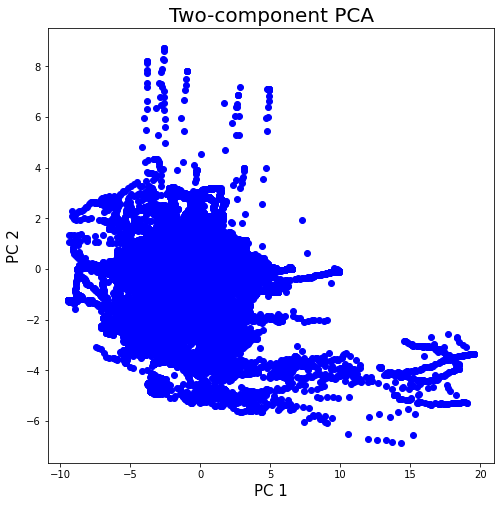

In [9]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)
plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], color='b')

# Méthodes d'outliers

In [74]:
def fit_predict(df, clf):
    clf.fit(df)
    ypred = clf.predict(df)
    return ypred

def plot2D(df, clf_name, contaminations, fig, ypred, i):
    ax = fig.add_subplot(int(len(contaminations)+1/2),2,i+1)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA \n Method : {} \n Contamination rate : {}'.format(clf_name,round(contaminations[i],3)))
    plt.scatter(df["principal component 1"], df["principal component 2"], color='b', label='Valid data')
    plt.plot(df["principal component 1"][ypred==-1],df["principal component 2"][ypred==-1],'r.', label='Anomalies')
    plt.legend(loc='upper right')

In [82]:
def runAnomalies(df, clf_name, contaminations, display=True):
    
    if display:
        fig = plt.figure(figsize=(20,10*int(len(contaminations)+1/2)))
        
    if clf_name == 'SVM':
        for i in range(len(contaminations)):
            # Create classificator
            clf = OneClassSVM(nu=contaminations[i], kernel="rbf", gamma=0.3)
            
            # Predict
            ypred = fit_predict(df, clf)
            
            # Plot
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
            
    elif clf_name == 'Elliptic':
        for i in range(len(contaminations)):
            # Create classificator
            clf = EllipticEnvelope(contamination=contaminations[i])
            
            # Predict
            ypred = fit_predict(df, clf)
            
            # Plot
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
            
    elif clf_name == 'Forest':
        for i in range(len(contaminations)):
            # Create classificator
            clf = IsolationForest(behaviour='new', n_estimators=100, contamination=contaminations[i])
            
            # Predict
            ypred = fit_predict(df, clf)
            
            # Plot
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
            
    elif clf_name == 'LOF':
        for i in range(len(contaminations)):
            # Create classificator
            clf = LocalOutlierFactor(n_neighbors=5, contamination=contaminations[i], novelty=True)
            
            # Predict
            ypred = fit_predict(df, clf)
            
            # Plot
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
            
    else:
        print("Error : The method is not known. Please select either 'SVM', 'Elliptic', 'Forest' or 'LOF'.")
        
    return ypred

array([ 1,  1, -1, ...,  1,  1,  1])

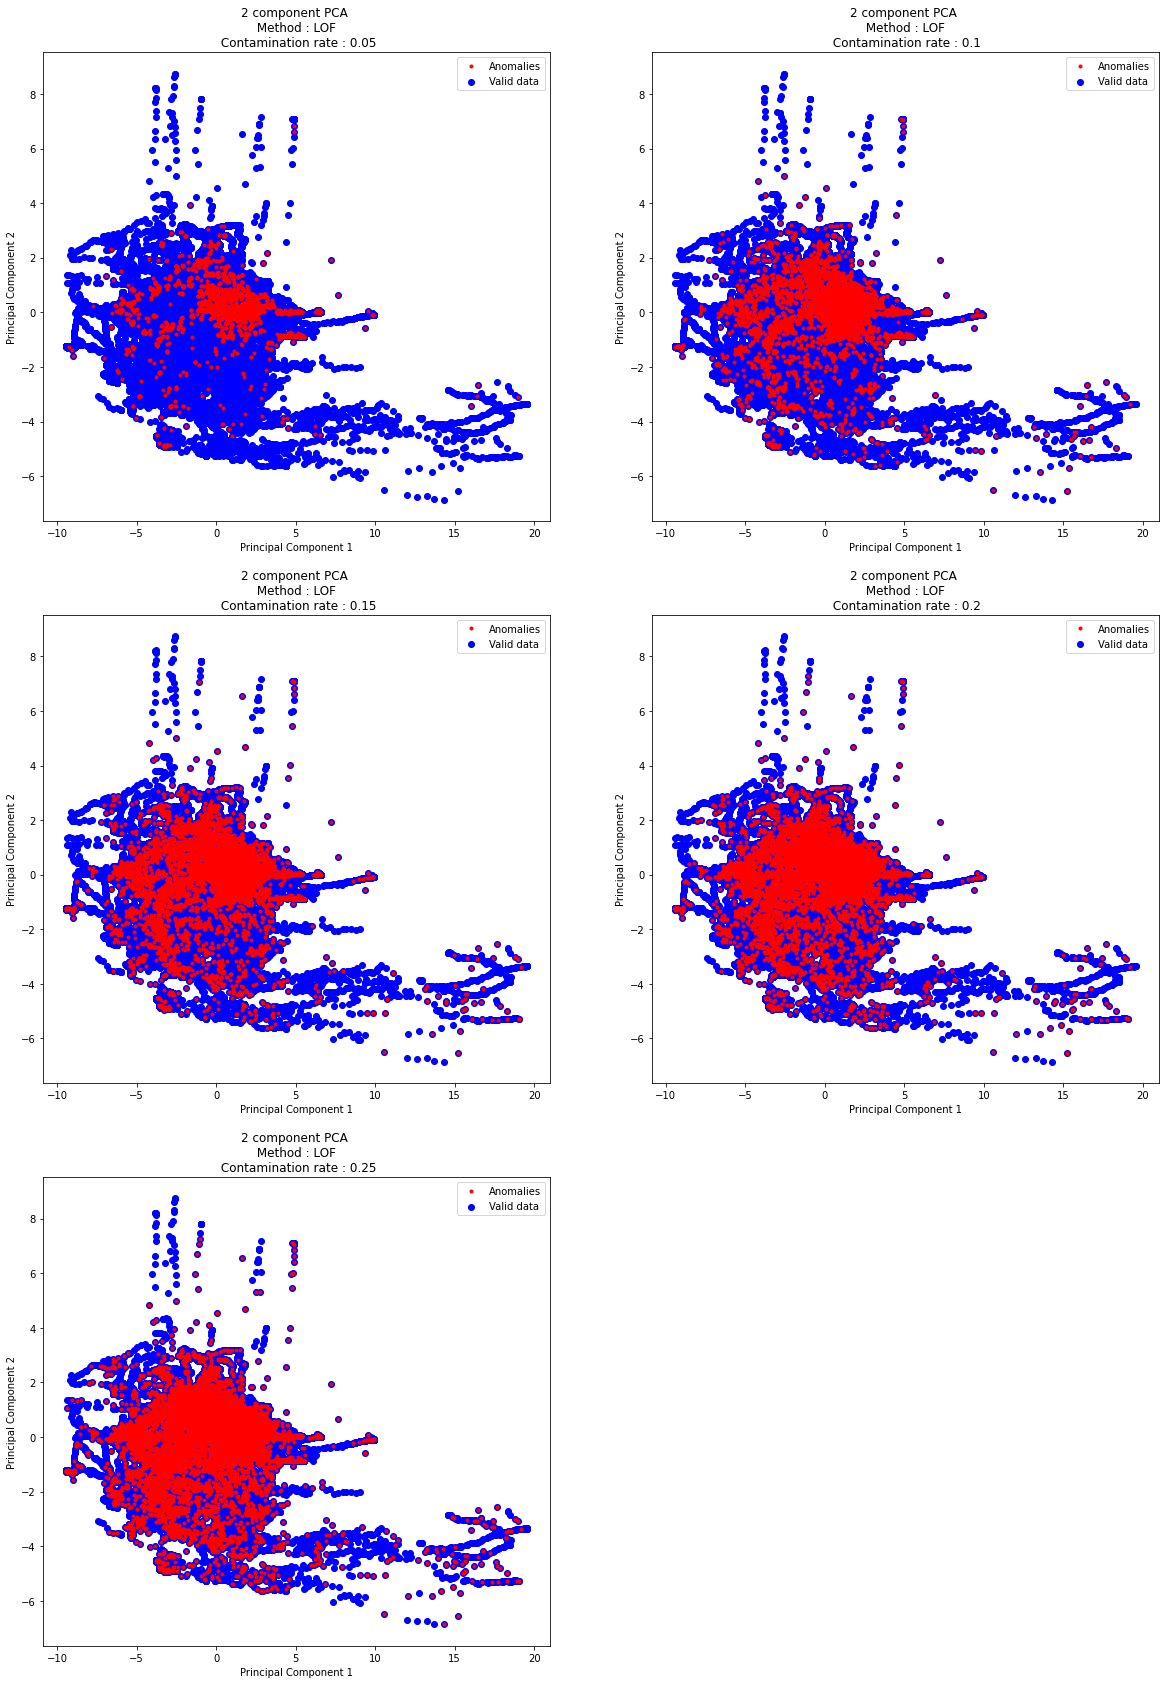

In [83]:
contaminations = np.linspace(0.05,0.25,5)
clf_name = "LOF"
runAnomalies(principalDf, clf_name, contaminations)

On regarde si une donnée est détectée par plusieurs méthodes grâce au score d'une donnée. On définit le score comme étant l'opposé de la somme des prédictions. Si une donnée a un score supérieur ou égal à 0, c'est qu'elle a été détectée comme étant une anomalie par au moins deux méthodes.
Pour éviter un temps de calcul trop long, nous menons cette étude pour seulement une valeur de contamination rate égale à 0,15.

In [ ]:
methods = ["Elliptic", "LOF", "SVM", "Forest"]
predictions = []
for clf_name in methods:
    print("Method : {}".format(clf_name))
    predictions.append(runAnomalies(principalDf, clf_name, [0.15], False))

score = [-1*sum(predictions[:,i]) for i in range(len (predictions))]

print(score[:7])

# Tentative d'étude des moyennes et std

In [48]:
data = pd.read_csv("./data/dataset.csv")
df = data.groupby(['day_cycle_window']).mean()

print(df.shape[1])
means = [df['p{}'.format(i+1)].mean() for i in range(df.shape[1])]
print(means)

df

11
[0.0012382429317027957, 0.0022032655043842356, 0.004516185710092517, 0.0012267911135197338, 0.0020019445926268, -0.00017456174893335077, 0.0006256022842985659, 0.0006998953140561237, -0.00465706109632071, 0.004040357403079036, 0.005881312325289908]


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
day_cycle_window,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059
...,...,...,...,...,...,...,...,...,...,...,...
4_4_95,-0.372836,0.141482,-0.149731,0.024193,0.623414,0.574988,-0.137674,-0.985834,0.935814,0.716441,-0.683516
4_4_96,-0.422993,0.074675,-0.178621,-0.197507,0.619532,0.805870,0.327148,-1.005362,0.924742,0.226022,-0.722753
4_4_97,-0.453629,0.040768,-0.130621,-0.370856,0.415872,0.808718,0.620583,-0.986663,0.905289,0.171044,-0.741979
